# DEEP LEARNING IN FINANCE

Finance is a very complex and computationally intensive domain with huge data.
The existing machine learning models used like supervised, unsupervised etc suffers from many problems such as overfitting, poor
accuracy due to its data complexity and non-linearity in its factors.

So, for efficient model building, deep learning models are used in the finance field owing to its capability to
learn from large unlabelled data, recurrent models, image recognition, non-linear models etc.

## Use cases of Deep Learning in Finance

#### 1. Pricing :
        Fixing or deciding prices.
#### 2. Portfolio Construction :
       Process of selecting the optimum mix of securities for the purpose of achieving maximum returns by taking minimum risk. A portfolio is a combination of various securities such as stocks, bonds and money market instruments.
#### 3. Risk Management
#### 4. High frequency trading

## Stock Prediction of TATA dataset

The TATA stock dataset is taken for this use case discussion 

#### Objective - Checking if closing prices of stocks will be increasing or decreasing.

The dataset contains multiple variables – Date, Open, High, Low, Last, Close, Total_Trade_Quantity, and Turnover.

 Open  - The starting price at which the stock is traded on a particular day.
 
 Close - The final price at which the stock is traded on a particular day.
 
 High  - The maximum price of the share for the day.
 
 Low   - The minimum price of the share for the day.
 
 Last  - The last price of the share for the day.
 
Total Trade Quantity - Number of shares bought or sold in the day.

Turnover (Lacs) - Turnover of the particular company on a given date.

## Convolution Neural Network

Convolution Neural Networks, are made up of neurons with weights and biases. 
Each neuron receives several inputs, takes a weighted sum over them, pass it through an activation function and 
responds with an output. They also have a loss function and optimization functions used while back propogation.

### Architecture of CNN:

1. Convolution Layer - Main building block of a convolutional neural network. It has independent filters to extract
 features from the data.
    
2. Pooling layer - Responsible for reducing the size of the Convolved Feature. 
Pooling Technique Used - Max Pooling returns the maximum value from the portion of the data.

3. Fully Connected Layer - The FC is the fully connected layer of neurons at the end of CNN. 
Neurons in a fully connected layer have full connections to all activations in the previous layer

## Stock Prediction using Convolution Neural Network

Stock prediction is a Time Series problem where the data includes a time series component and future values will be
predicted based on observed values.

Stock prediction is a univariate dataset having one dimensional data instead of traditional two dimensional 
data(image classification).

So, we can construct Univariate CNN model and predict the future outcomes of the stock.

### Importing libraries

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from numpy import array
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import logging

### Logging

In [141]:
logging.basicConfig(filename="stock_prediction.log", 
                    format='%(asctime)s %(message)s', 
                    filemode='w') 
logger=logging.getLogger() 
  
logger.setLevel(logging.DEBUG)


### Reading the dataset with Exception Handling

In [142]:
logger.info('--------STOCK PREDICTION USING CONVOLUTION NEURAL NETWORK---------')
try:
    df = pd.read_csv('NSE-TATAGLOBAL.csv')
    logger.info('TATA Stock Dataset read')
    print(df.head())
except IOError as e:
    print('File cannot be read')
    logger.info('File cannot be read')


         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-09-28  234.05  235.95  230.20  233.50  233.75               3069914   
1  2018-09-27  234.55  236.80  231.10  233.80  233.25               5082859   
2  2018-09-26  240.00  240.00  232.50  235.00  234.25               2240909   
3  2018-09-25  233.30  236.75  232.00  236.25  236.10               2349368   
4  2018-09-24  233.55  239.20  230.75  234.00  233.30               3423509   

   Turnover (Lacs)  
0          7162.35  
1         11859.95  
2          5248.60  
3          5503.90  
4          7999.55  


In [143]:
df.shape

(2035, 8)

### Features to consider:

Closing price is normally considered for determining profit and loss calculation. 
#### Close - feature will be considered for our model

## Close variable plot distribution

### 'Date' vs 'Close'

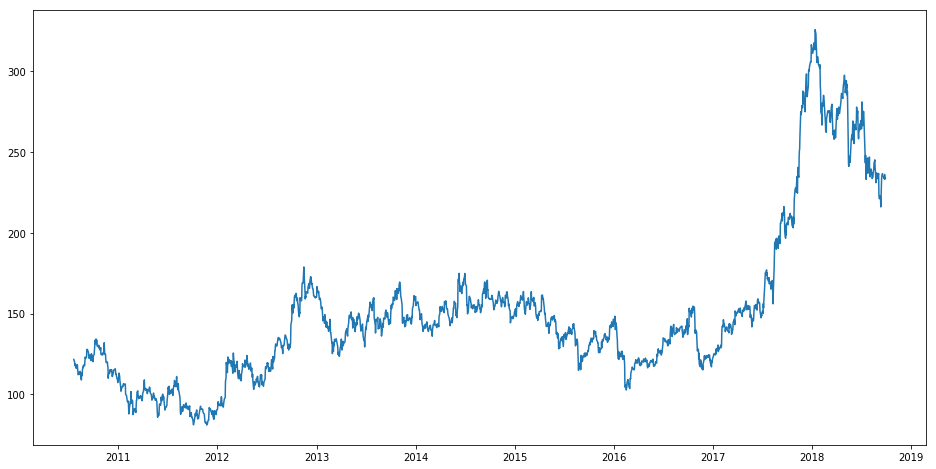

In [144]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
#print(df.head(5))
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price')
logger.info("Data visualised with matplotlib 'Date' vs 'Close'")

#### Observation:

We can observe a trend in the dataset. We see the stock price increase with year.

### Creating new dataframe with 'Date' and 'Close' columns

In [145]:
# Sorting the dataframe w.r.t Date 
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    
new_data.head(5)
logger.info("New Dataframe created with 'Date' and 'Close' features")

In [146]:
# Setting Date as the index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
new_data.head(5)


,Close
Date,
2010-07-21,121.55
2010-07-22,120.9
2010-07-23,120.65
2010-07-26,117.6
2010-07-27,118.65


### Data Preparation
For data preparation, sequence of observations must be divided into multiple input/output patterns
called samples, where multiple time steps are used as input and one time step is used as output for  prediction.

The input to the model should have 3 parameters:

1) Sample - One sequence is one sample. A batch is comprised of one or more samples.

2) Time step - One time step is one point of observation in the sample.(timesteps = 60)

3) Features - One feature is one observation at a time step(features = 1 since we have one dimensional data)

In [148]:
logger.info('------DATA PREPARATION------')
# Initialising features and timestep value
features = 1
t_steps  = 60
logger.info('Features:%d, timesteps:%d',features,t_steps)

In [149]:
train_set = new_data[:1600] # 80% of data
valid = new_data[1600:]
train_set.shape, valid.shape
logger.info('Dataset split into train and test sets')

In [150]:
train_set = np.array(train_set)

#### Split function:
 The below function splits the dataset into multiple samples with 60 timesteps each.
    
Example: Consider a given univariate sequence:

[10, 20, 30, 40, 50, 60, 70, 80, 90]

We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned.

X,				y
10, 20, 30		40
20, 30, 40		50
30, 40, 50		60


In [151]:
def split_sequence(sequence, t_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + t_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

X, y = split_sequence(train_set, t_steps)
logger.info('Training data transformed into 3 dimensional input[samples, timesteps and features]')

#### Reshaping the data into 3-dimensional input

In [152]:
X = X.reshape((X.shape[0], X.shape[1], features))
X.shape


(1540, 60, 1)

### Building CNN Model

In [153]:
logger.info('---------BUILDING CONVOLUTION NEURAL NETWORK---------')
model = Sequential()

# First layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(t_steps, features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))


### Parameters:

#### 1) Conv1D Layer -
This is a convolution layer that creates a convolution kernel that is convolved with the layer input over 
a single dimension to produce a tensor of outputs.

   #### Arguments:
    1. filters:  the number of output filters in the convolution.
    2. kernel_size: An integer, specifying the length of the 1D convolution window. 
    3. activation: Activation function to use.
       Rectified Linear Unit -ReLU is linear (identity) for all positive values, and zero for all negative values.
       Mathematically, it is defined as y = max(0, x).
    
#### 2) MaxPooling1D
This is a pooling layer that does Max pooling operation for the data.

   #### Arguments:

    1. pool_size: Integer, size of the max pooling windows.

#### 3) Flatten

This is a core layer that flattens the input.

#### 4) Dense

This is a core layer that implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer

   #### Arguments:

        units: Positive integer, dimensionality of the output space.

### Model Optimisation and Loss function:

#### 1) Optimisation function - 

#### Adam(Adaptive Moment Estimation)

Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters. Combination of RMSProp and AdaGrad functions.

 Adam uses estimations of first and second moments of gradient to adapt the learning rate for each weight of the neural network.N-th moment of a random variable is defined as the expected value of that variable to the power of n. More formally:
                 m =E[X pow n]


1. Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

2. Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Instead of adapting the parameter learning rates based on the average first moment as in RMSProp, Adam also makes use of the average of the second moments of the gradients.

#### 2) Loss function - Mean Squared Error

The mean squared error (MSE) measures the average of the squares of the errors — that is, the average squared difference 



In [154]:
logger.info('-------MODEL OPTIMISATION-------')
model.compile(optimizer='adam', loss='mse')
logger.info('Optimiser used is ADAM')
logger.info('Loss metric is Mean Squared Error')

### Building the model

In [155]:
model.fit(X, y, epochs=200, batch_size = 32)
logger.info('Model is trained for 200 epochs with batch size 32')

Epoch 1/200
1540/1540 [==============================] - 2s 1ms/step - loss: 1004.5272
Epoch 2/200
1540/1540 [==============================] - 0s 318us/step - loss: 104.5759
Epoch 3/200
1540/1540 [==============================] - 0s 324us/step - loss: 88.8979
Epoch 4/200
1540/1540 [==============================] - 0s 308us/step - loss: 81.0808
Epoch 5/200
1540/1540 [==============================] - 0s 320us/step - loss: 70.4621
Epoch 6/200
1540/1540 [==============================] - 0s 305us/step - loss: 62.6449
Epoch 7/200
1540/1540 [==============================] - 0s 299us/step - loss: 56.8059
Epoch 8/200
1540/1540 [==============================] - 0s 300us/step - loss: 54.5580
Epoch 9/200
1540/1540 [==============================] - 1s 326us/step - loss: 47.3410
Epoch 10/200
1540/1540 [==============================] - 0s 316us/step - loss: 48.4491
Epoch 11/200
1540/1540 [==============================] - 0s 304us/step - loss: 45.6722
Epoch 12/200
1540/1540 [================

Epoch 94/200
1540/1540 [==============================] - 0s 313us/step - loss: 20.4688
Epoch 95/200
1540/1540 [==============================] - 0s 299us/step - loss: 18.2308
Epoch 96/200
1540/1540 [==============================] - 0s 298us/step - loss: 17.2099
Epoch 97/200
1540/1540 [==============================] - 0s 316us/step - loss: 19.67320s - l
Epoch 98/200
1540/1540 [==============================] - 0s 304us/step - loss: 15.9616
Epoch 99/200
1540/1540 [==============================] - 0s 308us/step - loss: 17.1607
Epoch 100/200
1540/1540 [==============================] - 0s 290us/step - loss: 18.8927
Epoch 101/200
1540/1540 [==============================] - 0s 310us/step - loss: 20.0993
Epoch 102/200
1540/1540 [==============================] - 0s 302us/step - loss: 16.0062
Epoch 103/200
1540/1540 [==============================] - 0s 284us/step - loss: 16.2708
Epoch 104/200
1540/1540 [==============================] - 0s 291us/step - loss: 23.8973
Epoch 105/200
1540/15

### Test data preparation

In [156]:
logger.info('----------TEST DATA PREDICTION---------')

In [157]:
test= new_data[len(new_data) - len(valid) - 60:].values #(2035-435-60 = 1540)
print(test.shape)
test = test.reshape(-1,1)
print(test.shape)

X_test, y_test = split_sequence(test, t_steps)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], features))
X_test.shape
logger.info('Test data is prepared with shape %s',X_test.shape)

(495, 1)
(495, 1)


### Prediction on test data

In [158]:
predictions = model.predict(X_test)
predictions.shape, X_test.shape
logger.info('Stock prices for test data are predicted')

### Visualization

C:\Users\Lenovo-Pc\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


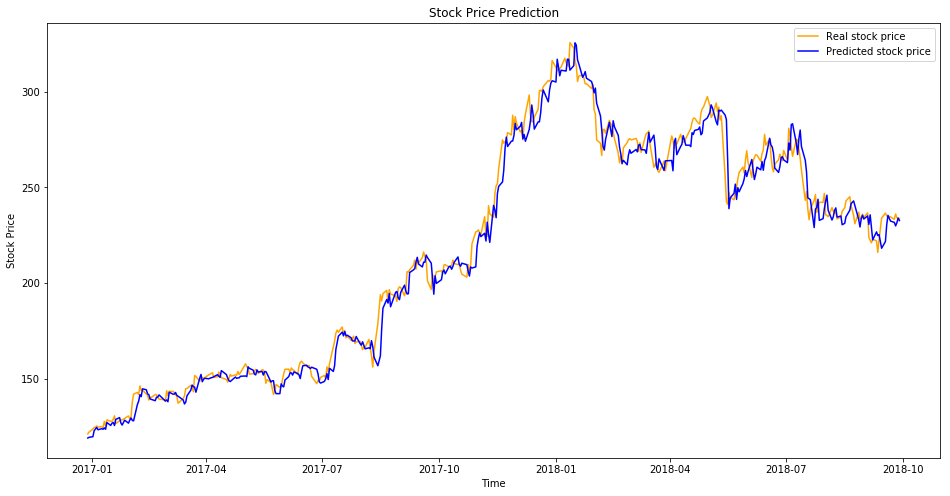

In [159]:
valid = new_data[1600:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(valid['Close'],color ='orange',label='Real stock price')
plt.plot(valid['Predictions'], color ='blue', label ='Predicted stock price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [160]:
logger.info('--------PERFORMANCE METRIC------')

In [161]:
rms=np.sqrt(np.mean(np.power((valid['Close']-valid['Predictions']),2)))
print(rms)
logger.info('Performance metric is RMS, RMS value:%f',rms)


7.311463281085214


## Stock Prediction using Recurrent Neural Network - LSTM

### Recuurent Neural Networks

Stock prediction is a sequence prediction problem where stock prices depend on stock values from previous days too, which is a major deciding factor.

In CNN models, the model doesn't consider the previous day stock prices(independent test cases), so the prediction would not be accurate.

So, this time dependency can be achieved using Recurrent Neural Network(RNN) models.
In RNN, every prediction at time t (h_t) is dependent on all previous predictions(h_t-1) and the information learned from them.

#### Limitations of RNN:

1. RNN can remember only short term dependencies(small duration of time)..

2. When RNN has to add a new information, it transforms the complete information by applying a function. So, there is no distinction between 'important' information and 'unimportant' information.

So, to overcome such shortcomings, we can use Long Short-Term Memory Networks.

## Long Short-Term Memory Networks

LSTM is a tweaked version of RNN, which can selectively forget or remember information(longer period of time).
When LSTM needs to add information, it makes small modifications rather than transforming the whole information unlike RNN.
In LSTM, information flows through a mechanism called cell states.

 The stock price of today will depend upon:

1. The trend that the stock has been following in the previous days, maybe a downtrend or an uptrend.
2. The price of the stock on the previous day, because many traders compare the stock’s previous day price before buying it.
3. The factors that can affect the price of the stock for today.

Generalizing the above factors in LSTM terms, 
1. The previous cell state (i.e. the information that was present in the memory after the previous time step).
2. The previous hidden state (i.e. this is the same as the output of the previous cell).
3. The input at the current time step (i.e. the new information that is being fed in at that moment).


A typical LSTM network is comprised of different memory blocks called cells.  There are two states that are being transferred to the next cell.
- the cell state
- the hidden state. 

The memory blocks are responsible for remembering things and manipulations to this memory is done through three major mechanisms, called gates.There are 3 gates:

#### 1) Forget gate
       A forget gate is responsible for removing information from the cell state. The information that is no longer required for the LSTM to understand things or the information that is of less importance is removed.
       
#### 2) Input gate
     The input gate is responsible for the addition of information to the cell state.
     
#### 3) Output gate
      The job of selecting useful information from the current cell state and showing it out as an output is done via the output gate. 

### Importing required libraries

In [162]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [163]:
logger.info('---------STOCK PREDICTION USING LONG SHORT-TERM MEMORY NETWORK (RNN)-----------')

### Reading dataset with Exception Handling

In [164]:
try:
    df = pd.read_csv('NSE-TATAGLOBAL.csv')
    print(df.head())
    logger.info('Dataset is read into dataframe')
    
except IOError as e:
    logger.info('File cannot be read')
    logger.info(e)

         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-09-28  234.05  235.95  230.20  233.50  233.75               3069914   
1  2018-09-27  234.55  236.80  231.10  233.80  233.25               5082859   
2  2018-09-26  240.00  240.00  232.50  235.00  234.25               2240909   
3  2018-09-25  233.30  236.75  232.00  236.25  236.10               2349368   
4  2018-09-24  233.55  239.20  230.75  234.00  233.30               3423509   

   Turnover (Lacs)  
0          7162.35  
1         11859.95  
2          5248.60  
3          5503.90  
4          7999.55  


### Creating new dataframe with only Date and Close features

In [165]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

dataset = new_data.values



### Splitting into train and valid test

In [166]:
train = dataset[0:987,:]
valid = dataset[987:,:]
print(train.shape, valid.shape)

(987, 1) (1048, 1)


### Data Normalization

In [167]:
logger.info('------DATA NORMALIZATION-------')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

C:\Users\Lenovo-Pc\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [168]:
scaled_data.shape

(2035, 1)

### Data Preparation

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

Samples - One sequence is one sample. A batch is comprised of one or more samples.

Time Steps - One time step is one point of observation in the sample.(timesteps = 60)

Features - One feature is one observation at a time step(features = 1)

In [169]:
logger.info('------DATA PREPARATION-------')

#### Splitting the data for 60 timesteps in one sample

In [170]:
x_train, y_train = [], []
for i in range(60,len(train)):  #927 iterations(987-60)
    #print(scaled_data[i-60:i,0])
    #print(scaled_data[i,0])
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
print(len(x_train), len(y_train))

927 927


#### Reshaping the array into 3-dimensional array

The reshape() function on the NumPy array to reshape this two-dimensional array
into a three-dimensional array with 927 sample, 60 time steps, and 1 feature at each time step.

In [171]:
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

(927, 60)
(927, 60, 1)


#### Creation of LSTM network


In [172]:
logger.info('-------LSTM NETWORK CREATION--------')

In [173]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(1))

logger.info('LSTM network constructed with 2 LSTM layers, 2 Dropout layers, 1 Dense layer')

#### LSTM Layer 
 Adds a LSTM later with 50 memory units(cells).
 
 return sequences - output hidden state values for all timesteps instead of the last timestep alone.

#### Dropout layer
Drops 20% of neurons to prevent over-fitting of data.

#### Dense layer
This is a core layer that implements the operation: output = activation(dot(input, kernel) + bias) where activation is the 
element-wise activation function passed as the activation argument, kernel is a weights matrix
created by the layer, and bias is a bias vector created by the layer

#### Compilation 
Configuring the learning process of the model with loss function and optimizer function.

Loss function - Mean squared error

Optimizer     - Adam

In [174]:
logger.info('------MODEL OPTIMISATION-------')

model.compile(loss='mean_squared_error', optimizer='adam')

logger.info('Optimisation function is ADAM, loss function is Mean squared error')

In [175]:
logger.info('-----MODEL BUILDING------')
model.fit(x_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
927/927 [==============================] - 7s 7ms/step - loss: 0.0331
Epoch 2/100
927/927 [==============================] - 4s 4ms/step - loss: 0.0036
Epoch 3/100
927/927 [==============================] - 4s 4ms/step - loss: 0.0030
Epoch 4/100
927/927 [==============================] - 3s 4ms/step - loss: 0.0029
Epoch 5/100
927/927 [==============================] - 3s 4ms/step - loss: 0.0029
Epoch 6/100
927/927 [==============================] - 4s 4ms/step - loss: 0.0027
Epoch 7/100
927/927 [==============================] - 3s 4ms/step - loss: 0.0027
Epoch 8/100
927/927 [==============================] - 3s 4ms/step - loss: 0.0028
Epoch 9/100
927/927 [==============================] - 3s 4ms/step - loss: 0.0023
Epoch 10/100
927/927 [==============================] - 4s 4ms/step - loss: 0.0025
Epoch 11/100
927/927 [==============================] - 4s 4ms/step - loss: 0.0023
Epoch 12/100
927/927 [==============================] - 3s 4ms/step - loss: 0.0025
Epoch 13/100


### Test data preparation

In [176]:
logger.info('----TEST DATA PREPARATION-----')
print(len(new_data),len(valid))
#To know from where the test data starts(from 927:)
inputs = new_data[len(new_data) - len(valid) - 60:].values #2035-1048-60 = 927
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs  = scaler.transform(inputs)
print(inputs.shape[0])

2035 1048
(1108, 1)
(1108, 1)
1108


#### Reshaping test data into 3-dimensional array with 1048 samples, 60 timesteps, 1 feature

In [177]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(1048, 60)
(1048, 60, 1)


#### Prediction for test data

In [178]:
logger.info('------TEST DATA PREDICTION-------')
closing_price = model.predict(X_test)
print(closing_price)

[[0.3199916 ]
 [0.31864038]
 [0.31808323]
 ...
 [0.15303828]
 [0.15562527]
 [0.15886052]]


#### Inversing the data to original form

In [179]:
closing_price = scaler.inverse_transform(closing_price)
print(closing_price)

[[159.28394 ]
 [158.95316 ]
 [158.81677 ]
 ...
 [118.413765]
 [119.047066]
 [119.83905 ]]


### Visualization of predicted data

C:\Users\Lenovo-Pc\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


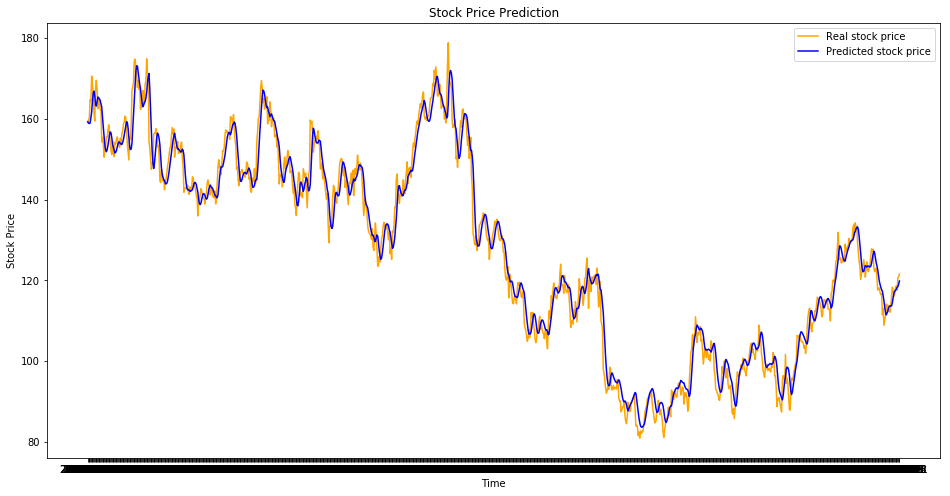

In [180]:
valid = new_data[987:]

valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(valid['Close'],color ='orange',label='Real stock price')
plt.plot(valid['Predictions'], color ='blue', label ='Predicted stock price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### RMS value

In [181]:
logger.info('-------PERFORMANCE METRIC FOR LSTM-------')
rms=np.sqrt(np.mean(np.power((valid['Close']-valid['Predictions']),2)))

logger.info('RMS:%f'%rms)
rms

3.824134092258396

### Comparison of CNN over LSTM model for stock market

The RMS value for CNN model is 7.3

The RMS value for LSTM model is 3.8

The LSTM model performs better than CNN with RMS as performance metrics and also due to its ability to 
have long term dependencies across inputs.

## Conclusion:

LSTM is a better model than CNN for stock market prediction.